# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from collections import Counter
from matplotlib_venn import venn2, venn3
from scipy import stats
UKBB_PATH = '../glaucoma_project/UKBB_Data/'
UKBB_GENOME_PATH = '../glaucoma_project/UKBB_Data_Basket2/raw_genome/merged_raw_genome/'
UKBB_IMPUTED_GENOME_PATH = '../glaucoma_project/UKBB_Data_Basket2/imputed_genome/merged_imputed_genome/'
GWAS_PATH = '../glaucoma_project/GWAS/'
from tableone import TableOne
import statsmodels.api as sm
import re
import seaborn as sns
import gzip
import time
import venn

In [2]:
poag_gwas = pd.read_csv(GWAS_PATH+'gwas-association-downloaded_2021-12-10-open-angle-glaucoma.tsv',sep='\t')
any_glaucoma_gwas = pd.read_csv(GWAS_PATH+'gwas-association-downloaded_2021-12-13-any-glaucoma.tsv',sep='\t')
iop_gwas = pd.read_csv(GWAS_PATH+'gwas-association-downloaded_2021-12-13-iop.tsv',sep='\t')
low_tension_gwas = pd.read_csv(GWAS_PATH+'gwas-association-downloaded_2021-12-13-low-tension-glaucoma.tsv',sep='\t')
vcdr_gwas = pd.read_csv(GWAS_PATH+'gwas-association-downloaded_2021-12-13-vcdr.tsv',sep='\t')

In [3]:
poag_gwas.columns

Index(['DATE ADDED TO CATALOG', 'PUBMEDID', 'FIRST AUTHOR', 'DATE', 'JOURNAL',
       'LINK', 'STUDY', 'DISEASE/TRAIT', 'INITIAL SAMPLE SIZE',
       'REPLICATION SAMPLE SIZE', 'REGION', 'CHR_ID', 'CHR_POS',
       'REPORTED GENE(S)', 'MAPPED_GENE', 'UPSTREAM_GENE_ID',
       'DOWNSTREAM_GENE_ID', 'SNP_GENE_IDS', 'UPSTREAM_GENE_DISTANCE',
       'DOWNSTREAM_GENE_DISTANCE', 'STRONGEST SNP-RISK ALLELE', 'SNPS',
       'MERGED', 'SNP_ID_CURRENT', 'CONTEXT', 'INTERGENIC',
       'RISK ALLELE FREQUENCY', 'P-VALUE', 'PVALUE_MLOG', 'P-VALUE (TEXT)',
       'OR or BETA', '95% CI (TEXT)', 'PLATFORM [SNPS PASSING QC]', 'CNV',
       'MAPPED_TRAIT', 'MAPPED_TRAIT_URI', 'STUDY ACCESSION',
       'GENOTYPING TECHNOLOGY'],
      dtype='object')

# Get SNPS

In [3]:
def get_snps(gwas_df):
    snps = gwas_df['SNPS'].drop_duplicates().values
    snps = [bytes(snp, encoding='utf8') for snp in snps]
    return set(snps)

<AxesSubplot:>

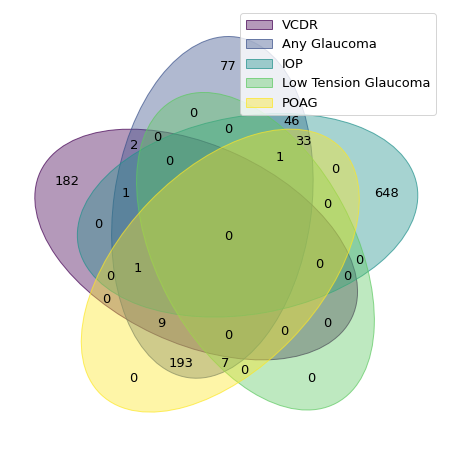

In [4]:
venn.venn({'VCDR':get_snps(vcdr_gwas),
           'Any Glaucoma':get_snps(any_glaucoma_gwas),
           'IOP':get_snps(iop_gwas),
           'Low Tension Glaucoma':get_snps(low_tension_gwas),
           'POAG':get_snps(poag_gwas)})

In [6]:
len(vcdr_gwas), len(any_glaucoma_gwas), len(iop_gwas), len(low_tension_gwas), len(poag_gwas)

(290, 556, 952, 9, 341)

In [7]:
snps = set(get_snps(poag_gwas)).union(set(get_snps(any_glaucoma_gwas)), set(get_snps(iop_gwas)), set(get_snps(low_tension_gwas)), set(get_snps(vcdr_gwas)))

In [8]:
len(snps)

1200

In [8]:
combined_snp_df = pd.concat([poag_gwas,low_tension_gwas,any_glaucoma_gwas,iop_gwas,vcdr_gwas])[['CHR_ID','CHR_POS','SNPS']]

In [9]:
combined_snp_df['CHR_ID'] = combined_snp_df['CHR_ID'].apply(lambda x: np.nan if pd.isna(x) else ('X' if x == 'X' else int(x)))
combined_snp_df['CHR_POS'] = combined_snp_df['CHR_POS'].apply(lambda x: -99999 if pd.isna(x) else int(x))

In [10]:
combined_snp_df = combined_snp_df.drop_duplicates()

In [11]:
combined_snp_df['POAG'] = combined_snp_df['SNPS'].apply(lambda x: x in poag_gwas['SNPS'].values)
combined_snp_df['LTG'] = combined_snp_df['SNPS'].apply(lambda x: x in low_tension_gwas['SNPS'].values)
combined_snp_df['ANY_GLAUCOMA'] = combined_snp_df['SNPS'].apply(lambda x: x in any_glaucoma_gwas['SNPS'].values)
combined_snp_df['IOP'] = combined_snp_df['SNPS'].apply(lambda x: x in iop_gwas['SNPS'].values)
combined_snp_df['VCDR'] = combined_snp_df['SNPS'].apply(lambda x: x in vcdr_gwas['SNPS'].values)

Need to convert SNPs from GRCh38.p13 to GRCh37.p13

In [12]:
combined_snp_df['ID_AND_POS'] = [str(id)+':'+str(pos) for id, pos in zip(combined_snp_df['CHR_ID'], combined_snp_df['CHR_POS'])]

In [13]:
combined_snp_df['ID_AND_POS'].to_csv('id_and_pos.csv',index=False)

And then I ran the output through NCBI Remap

In [14]:
remap_df = pd.read_csv('report_remap_textarea.csv')

In [15]:
remap_df = remap_df[remap_df['asm_unit'] == 'Primary Assembly']

In [16]:
loc_mapping_dict = {(source_id, source_start): (mapped_id, int(mapped_start)) for source_id, source_start, mapped_id, mapped_start
 in zip(remap_df['source_id'], remap_df['source_start'], remap_df['mapped_id'], remap_df['mapped_start'])}

In [17]:
combined_snp_df['NEW_ID_AND_POS'] = [loc_mapping_dict[(str(id), int(pos))] if not pd.isna(id) and not int(pos) == 139866247 else np.nan for id, pos in zip(combined_snp_df['CHR_ID'], combined_snp_df['CHR_POS'])]

In [18]:
combined_snp_df['NEW_CHR_ID'] = combined_snp_df['NEW_ID_AND_POS'].apply(lambda x: np.nan if pd.isna(x) else x[0])
combined_snp_df['NEW_CHR_POS'] = combined_snp_df['NEW_ID_AND_POS'].apply(lambda x: -99999 if pd.isna(x) else int(x[1]))

In [19]:
chr_id_and_pos = [(snps[3:].split(':') if 'chr' in snps else snps.split(':')) if pd.isna(chr_id) and ':' in snps else chr_id for chr_id, snps in zip(combined_snp_df['NEW_CHR_ID'], combined_snp_df['SNPS'])]
combined_snp_df['NEW_CHR_ID'] = [new_id[0] if type(new_id) is list else id for id, new_id in zip(combined_snp_df['NEW_CHR_ID'], chr_id_and_pos)]
combined_snp_df['NEW_CHR_POS'] = [new_id[1] if type(new_id) is list else id for id, new_id in zip(combined_snp_df['NEW_CHR_POS'], chr_id_and_pos)]

In [20]:
combined_snp_df['SNPS'].to_csv('snps_list.list',index=False)

In [21]:
combined_snp_df['NEW_CHR_POS'].to_csv('pos_list.list',index=False)

In [22]:
combined_snp_df.reset_index(drop=True,inplace=True)

Look closely at any SNPs that don't have an rsID / don't have an ID and position

In [23]:
combined_snp_df[combined_snp_df['SNPS'].apply(lambda x: not 'rs' in x) | combined_snp_df['CHR_POS'].apply(lambda x: x == -99999)]

,CHR_ID,CHR_POS,SNPS,POAG,LTG,ANY_GLAUCOMA,IOP,VCDR,ID_AND_POS,NEW_ID_AND_POS,NEW_CHR_ID,NEW_CHR_POS
79,NaN,-99999,rs2710323,True,False,True,False,False,nan:-99999,NaN,NaN,-99999
106,NaN,-99999,exm1332165,True,False,True,False,False,nan:-99999,NaN,NaN,-99999
116,NaN,-99999,chr15:74221210,True,False,True,False,False,nan:-99999,NaN,15,74221210
146,NaN,-99999,rs8176749,True,False,True,False,False,nan:-99999,NaN,NaN,-99999
209,NaN,-99999,2:84828363,True,False,True,False,False,nan:-99999,NaN,2,84828363
323,NaN,-99999,chr1:169491924,False,False,True,False,False,nan:-99999,NaN,1,169491924
324,NaN,-99999,chr1:174602645,False,False,True,False,False,nan:-99999,NaN,1,174602645
335,NaN,-99999,SNP_A-2171106,False,False,True,False,False,nan:-99999,NaN,NaN,-99999
336,NaN,-99999,SNP_A-1841655,False,False,True,False,False,nan:-99999,NaN,NaN,-99999
370,NaN,-99999,chr9:139866247,False,False,False,True,False,nan:-99999,NaN,9,139866247


In [24]:
combined_snp_df['NEW_CHR_ID'].iloc[79] = 3
combined_snp_df['NEW_CHR_POS'].iloc[79] = 52815905

/home/cmay091/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [25]:
combined_snp_df['NEW_CHR_ID'].iloc[106] = 17
combined_snp_df['NEW_CHR_POS'].iloc[106] = 45451894
combined_snp_df['SNPS'].iloc[106] = 'rs4968318'
# found a table online that mapped exm1332165 to rs4968318

In [26]:
combined_snp_df['NEW_CHR_ID'].iloc[146] = 9
combined_snp_df['NEW_CHR_POS'].iloc[146] = 136131188

In [27]:
combined_snp_df['NEW_CHR_ID'].iloc[335] = 1
combined_snp_df['NEW_CHR_POS'].iloc[335] = 196679455
combined_snp_df['SNPS'].iloc[335] = 'rs10737680'
# found on Google

In [28]:
combined_snp_df['NEW_CHR_ID'].iloc[336] = 10
combined_snp_df['NEW_CHR_POS'].iloc[336] = 124215315
combined_snp_df['SNPS'].iloc[336] = 'rs3750848'
# found on Google

In [29]:
combined_snp_df['NEW_CHR_ID'].iloc[730] = 15
combined_snp_df['NEW_CHR_POS'].iloc[730] = 100692953
combined_snp_df['SNPS'].iloc[730] = 'rs72755233'

In [30]:
combined_snp_df['NEW_CHR_ID'].iloc[770] = 7
combined_snp_df['NEW_CHR_POS'].iloc[770] = 103188061

In [31]:
combined_snp_df['NEW_CHR_ID'].iloc[791] = 3
combined_snp_df['NEW_CHR_POS'].iloc[791] = 50199747

Duplicates

In [32]:
combined_snp_df[combined_snp_df['NEW_CHR_POS'] == 120348584]

,CHR_ID,CHR_POS,SNPS,POAG,LTG,ANY_GLAUCOMA,IOP,VCDR,ID_AND_POS,NEW_ID_AND_POS,NEW_CHR_ID,NEW_CHR_POS
866,11,120477875,rs199800298,False,False,False,True,False,11:120477875,"(11, 120348584)",11,120348584
888,11,120477875,rs10892583,False,False,False,True,False,11:120477875,"(11, 120348584)",11,120348584


In [33]:
combined_snp_df[combined_snp_df['NEW_CHR_POS'] == 100692953]

,CHR_ID,CHR_POS,SNPS,POAG,LTG,ANY_GLAUCOMA,IOP,VCDR,ID_AND_POS,NEW_ID_AND_POS,NEW_CHR_ID,NEW_CHR_POS
526,15,100152748,rs72755233,False,False,False,True,False,15:100152748,"(15, 100692953)",15,100692953
730,NaN,-99999,rs72755233,False,False,False,True,False,nan:-99999,NaN,15,100692953


In [34]:
combined_snp_df.drop_duplicates('NEW_CHR_POS',inplace=True)
combined_snp_df.reset_index(drop=True,inplace=True)

# Raw genome extraction

Imputed path: '../glaucoma_project/UKBB_Data_Basket2/imputed_genome/merged_imputed_genome/UKBB_imputed22828_chr1_7.bcf'

Raw path: '../glaucoma_project/UKBB_Data_Basket2/raw_genome/merged_raw_genome/UKBB_raw22418_chrALL.vcf.gz'

**Commands I have run:**


*Raw data*

!bcftools view -i'ID=@snps_list.list' '../glaucoma_project/UKBB_Data_Basket2/raw_genome/merged_raw_genome/UKBB_raw22418_chrALL.vcf.gz' --output-file '../glaucoma_project/UKBB_Data/processed_data/raw_data_by_id.txt'

when in the folder:

!bcftools index UKBB_raw22418_chrALL.vcf.gz

!bcftools view --regions-file 'id_and_pos.tsv' '../glaucoma_project/UKBB_Data_Basket2/raw_genome/merged_raw_genome/UKBB_raw22418_chrALL.vcf.gz' --output-file '../glaucoma_project/UKBB_Data/processed_data/raw_data_by_pos.txt' 

*Imputed data*

When in the folder:

nohup bcftools index UKBB_imputed22828_chr1_7.bcf & (10am, 06/04)

nohup bcftools index UKBB_imputed22828_chr8_22.bcf & (11:30pm, 10/04)

nohup bcftools index ukb22828_cX_b0_v3.bcf &

nohup bcftools index ukb22828_cXY_b0_v3.bcf &

!bcftools view --regions-file 'id_and_pos.tsv' '../glaucoma_project/UKBB_Data_Basket2/imputed_genome/merged_imputed_genome/UKBB_imputed22828_chr1_7.bcf' --output-file '../glaucoma_project/UKBB_Data/processed_data/extracted_snps_chr1_7.vcf' 

!bcftools view --regions-file 'id_and_pos.tsv' '../glaucoma_project/UKBB_Data_Basket2/imputed_genome/merged_imputed_genome/UKBB_imputed22828_chr8_22.bcf' --output-file '../glaucoma_project/UKBB_Data/processed_data/extracted_snps_chr8_22.vcf'

!bcftools view --regions-file 'id_and_pos.tsv' '../glaucoma_project/Vault/imputed_genome_perchr/ukb22828_cX_b0_v3.bcf' --output-file '../glaucoma_project/UKBB_Data/processed_data/extracted_snps_chrX.vcf'

!bcftools view --regions-file 'id_and_pos.tsv' '../glaucoma_project/Vault/imputed_genome_perchr/ukb22828_cXY_b0_v3.bcf' --output-file '../glaucoma_project/UKBB_Data/processed_data/extracted_snps_chrXY.vcf'

Creating ID and pos index to grab files

In [35]:
combined_snp_df['ARB_START'] = combined_snp_df['NEW_CHR_POS'].astype(int) - 100

In [36]:
combined_snp_df['ARB_END'] = combined_snp_df['NEW_CHR_POS'].astype(int) + 100

In [37]:
combined_snp_df[['NEW_CHR_ID','ARB_START','ARB_END']].to_csv('id_and_pos.tsv',sep='\t',index=False, header=False)

Grab files

In [329]:
t0 = time.time()
!bcftools view --regions-file 'id_and_pos.tsv' '../glaucoma_project/UKBB_Data_Basket2/imputed_genome/merged_imputed_genome/UKBB_imputed22828_chr1_7.bcf' --output-file '../glaucoma_project/UKBB_Data/processed_data/extracted_snps_chr1_7.vcf'
print(time.time() - t0)
!bcftools view --regions-file 'id_and_pos.tsv' '../glaucoma_project/UKBB_Data_Basket2/imputed_genome/merged_imputed_genome/UKBB_imputed22828_chr8_22.bcf' --output-file '../glaucoma_project/UKBB_Data/processed_data/extracted_snps_chr8_22.vcf'
print(time.time() - t0)

1142.3785998821259
2577.8629784584045


In [38]:
t0 = time.time()
!bcftools view --regions-file 'id_and_pos.tsv' '../glaucoma_project/Vault/imputed_genome_perchr/ukb22828_cX_b0_v3.bcf' --output-file '../glaucoma_project/UKBB_Data/processed_data/extracted_snps_chrX.vcf'
print(time.time() - t0)
!bcftools view --regions-file 'id_and_pos.tsv' '../glaucoma_project/Vault/imputed_genome_perchr/ukb22828_cXY_b0_v3.bcf' --output-file '../glaucoma_project/UKBB_Data/processed_data/extracted_snps_chrXY.vcf'
print(time.time() - t0)

10.79387903213501
11.415664434432983


In [38]:
def get_line_by_index(index, filename):
    this_line = None
    with open(UKBB_PATH+'processed_data/'+filename, 'r') as f:
        i = 0
        for line in tqdm(f, total=index):
            if i == index:
                this_line = line
                break
            i += 1
    return this_line.split('\t') 

In [39]:
header_line = get_line_by_index(17, 'extracted_snps_chr1_7.vcf')

100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 188.75it/s]


In [40]:
header_lineX = get_line_by_index(9, 'extracted_snps_chrX.vcf')

100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 371.67it/s]


In [41]:
lines = []
with open(UKBB_PATH+'processed_data/extracted_snps_chr1_7.vcf', 'r') as f:
    for line in tqdm(f, total=4274):
        this_line = line.split('\t')
        if this_line[0][0] != '#':
            lines.append(this_line[:9])

100%|██████████████████████████████████████| 4274/4274 [01:52<00:00, 38.09it/s]


In [42]:
with open(UKBB_PATH+'processed_data/extracted_snps_chr8_22.vcf', 'r') as f:
    for line in tqdm(f, total=5459):
        this_line = line.split('\t')
        if this_line[0][0] != '#':
            lines.append(this_line[:9])

100%|██████████████████████████████████████| 5459/5459 [02:23<00:00, 37.97it/s]


In [43]:
with open(UKBB_PATH+'processed_data/extracted_snps_chrX.vcf', 'r') as f:
    for line in tqdm(f, total=68):
        this_line = line.split('\t')
        if this_line[0][0] != '#':
            lines.append(this_line[:9])

100%|██████████████████████████████████████████| 68/68 [00:01<00:00, 49.36it/s]


In [44]:
with open(UKBB_PATH+'processed_data/extracted_snps_chrXY.vcf', 'r') as f:
    for line in tqdm(f, total=11):
        this_line = line.split('\t')
        if this_line[0][0] != '#':
            lines.append(this_line[:9])

100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 252.59it/s]


In [45]:
df_genes = pd.DataFrame(lines)
df_genes.columns = header_line[:9]

Once all data is found, clean things up and ensure all genes that should be found are found!

In [46]:
df_found_genes = df_genes[['#CHROM','POS','ID']].copy()

# Checking genes

In [47]:
pd.set_option('display.max_rows', 60)

In [48]:
pseudonym_dict = {'rs148639588':['rs112510995'],
                  'rs141853979':['rs3056626','rs397837288','rs36062648'],
                  'rs528855147':['rs74671105','rs1314073857','rs144815765','rs144396236'],
                  'rs113711540':['rs147577544'],
                  'rs376096585':['rs35060930','rs1341186093','rs397869466','rs376096585','rs201260075','rs60794279'],
                  'rs200621439':['rs386392514','rs374196753'],
                  'rs143937055':['rs373579190'],
                  'rs530696125':['rs1209027168'],
                  'rs71621907':['rs1321931851','rs1246801432','rs113235403'],
                  'rs11391380':['rs144550962'],
                  'rs565335773':['rs1336268124'],
                  'rs67530707':['rs61105472'],
                  'rs141917145':['rs5879193','rs767697481','rs142465318'],
                  'rs34421297':['rs1345468603','rs1233230502','rs56995305'],
                  'rs10563220':['rs1457932575','rs1239479552','rs1201159476','rs869278705','rs756827701','rs202089916','rs200101458','rs58488385'],
                  'rs59101260':['rs1491402433','rs1471115345','rs1461563858','rs1182727753','rs148399475','rs142526210','rs71520738'],
                  'rs572119521':['rs1447047493','rs1445240475','rs1427800483','rs1416244604','rs1389472911','rs1384550130','rs1354861749','rs1340617233',
                                 'rs1300657097','rs1296295903','rs1274346515','rs1270230974','rs1246054558','rs1231202965','rs1180284579','rs1168110712'],
                  'rs35740987':['rs370028232','rs368222632','rs77668933'],
                  'rs10625795':['rs1271611595','rs1216388609','rs369827588','rs145005474','rs66802010','rs35618892','rs34252018'],
                  'rs5785510':['rs1233881906','rs796918786','rs376867013','rs369272357','rs151199749','rs57530746','rs35963438'],
                  'rs66479974':['rs147919359','rs143979005'],
                  'rs369532258':['rs56779578','rs1491012635','rs1448577788','rs71055580'],
                  'rs146200153':['rs1357840162','rs57661425','rs375872596'],
                  'rs574982531':['rs57677939','rs139924361'],
                  'rs111870938':['rs1328634201','rs144413707'],
                  'rs545317462':['rs61523435','rs1491005611','rs1301472720','rs397946780','rs140229631','rs72145363'],
                  'rs150025731':['rs60071557','rs757885485'],
                  'rs5813732':['rs60354638'],
                  'rs148139847':['rs75979205'],
                  'rs373836950':['rs60114312','rs1434667405','rs1379333119','rs1173978273','rs202176721'],
                  'rs1348518145':['rs67114322','rs1491511282','rs140149407','rs398030955','rs71141921','rs67114325','rs67114324','rs67114323'],
                  'rs3831804':['rs397774125','rs371698565','rs148442591','rs66712532','rs56727649','rs34697894','rs5841118'],
                  'rs11422952':['rs776048795','rs746930778','rs397828592','rs139504330','rs34882229'],
                  'rs113605227':['rs144193994'],
                  'rs71324877':['rs199819336','rs142409308']
                 }

In [49]:
snp_found_in_the_right_position_but_wrong_mutation = ['rs200621439',
                                                     'rs10563220',
                                                     'rs199800298',
                                                     'rs5785510',
                                                     'rs66479974']

In [50]:
def confirm_presence_of_gene(chrom, pos, rsid):
    if rsid in df_found_genes['ID'].values:
        return 'ID present'
    if str(chrom)+':'+str(pos) in [str(c)+':'+str(p) for c,p in zip(df_found_genes['#CHROM'], df_found_genes['POS'])]:
        if rsid in snp_found_in_the_right_position_but_wrong_mutation:
            return 'Wrong SNP found at right position'
        else:
            return 'Position present'
    if rsid in pseudonym_dict.keys():
        for psuedonym in pseudonym_dict[rsid]:
            if psuedonym in df_found_genes['ID'].values:
                return 'Pseudonym present'
    return 'Absent'

In [51]:
combined_snp_df['Status'] = [confirm_presence_of_gene(chrom, pos, rsid) for chrom, pos, rsid in zip(combined_snp_df['NEW_CHR_ID'], combined_snp_df['NEW_CHR_POS'], combined_snp_df['SNPS'])]

In [52]:
combined_snp_df['Status'].value_counts()

ID present                           1166
Position present                       17
Absent                                  9
Wrong SNP found at right position       5
Pseudonym present                       1
Name: Status, dtype: int64

## Absent genes

In [53]:
combined_snp_df[combined_snp_df['Status'] == 'Absent']

,CHR_ID,CHR_POS,SNPS,POAG,LTG,ANY_GLAUCOMA,IOP,VCDR,ID_AND_POS,NEW_ID_AND_POS,NEW_CHR_ID,NEW_CHR_POS,ARB_START,ARB_END,Status
78,6,36625210,rs67530707,True,False,True,False,False,6:36625210,"(6, 36592987)",6,36592987,36592887,36593087,Absent
142,8,30596693,rs35740987,True,False,True,False,False,8:30596693,"(8, 30454210)",8,30454210,30454110,30454310,Absent
211,17,47617877,rs1348518145,True,False,True,False,False,17:47617877,"(17, 45695243)",17,45695243,45695143,45695343,Absent
249,6,148738155,rs190298731,False,False,True,False,False,6:148738155,"(6, 149059291)",6,149059291,149059191,149059391,Absent
300,15,73931160,rs150025731,False,False,True,False,False,15:73931160,"(15, 74223501)",15,74223501,74223401,74223601,Absent
319,1,100634623,rs148843724,False,False,True,False,False,1:100634623,"(1, 101100179)",1,101100179,101100079,101100279,Absent
320,1,102915337,rs141853979,False,False,True,False,False,1:102915337,"(1, 103380893)",1,103380893,103380793,103380993,Absent
324,NaN,-99999,chr1:174602645,False,False,True,False,False,nan:-99999,NaN,1,174602645,174602545,174602745,Absent
869,2,227279251,rs143937055,False,False,False,True,False,2:227279251,"(2, 228143967)",2,228143967,228143867,228144067,Absent


In [54]:
combined_snp_df[combined_snp_df['Status'] == 'Absent'].to_csv(UKBB_PATH+'processed_data/absent_genes.csv')

## Checking ID of genes that were found by location

In [55]:
found_by_position = combined_snp_df[combined_snp_df['Status'] == 'Position present'].copy()

In [56]:
ids = []
ref = []
alt = []
for chrom, pos in zip(found_by_position['NEW_CHR_ID'], found_by_position['NEW_CHR_POS']):
    id_list = df_genes[(df_genes['#CHROM'].astype(str) == str(chrom)) & (df_genes['POS'].astype(int) == int(pos))]['ID'].values
    ref.append(df_genes[(df_genes['#CHROM'].astype(str) == str(chrom)) & (df_genes['POS'].astype(int) == int(pos))]['REF'].values[0])
    alt.append(df_genes[(df_genes['#CHROM'].astype(str) == str(chrom)) & (df_genes['POS'].astype(int) == int(pos))]['ALT'].values[0])
    ids.append(id_list)

In [57]:
found_by_position['Located IDs'] = ids
found_by_position['REF'] = ref
found_by_position['ALT'] = alt

In [58]:
found_by_position.to_csv(UKBB_PATH+'processed_data/genes_found_by_loc.csv')

## Checking location of genes that were found by ID
Were the genes found in the places that they were claimed to be

In [59]:
id_present = combined_snp_df[combined_snp_df['Status'] == 'ID present'].copy()

In [60]:
id_present['FOUND_CHR_POS'] = id_present['SNPS'].apply(lambda x: df_genes[df_genes['ID'] == x]['POS'].values[0])

In [61]:
id_present['Offset'] = id_present['FOUND_CHR_POS'].astype(int) - id_present['NEW_CHR_POS']

In [62]:
id_present['Offset'].value_counts()

 0    1138
-1      28
Name: Offset, dtype: int64

Yes, they were found in the correct place

In [84]:
combined_snp_df[combined_snp_df['Status'] == 'Absent']

,CHR_ID,CHR_POS,SNPS,POAG,LTG,ANY_GLAUCOMA,IOP,VCDR,ID_AND_POS,NEW_ID_AND_POS,NEW_CHR_ID,NEW_CHR_POS,ARB_START,ARB_END,Status,ID in UKBB
78,6,36625210,rs67530707,True,False,True,False,False,6:36625210,"(6, 36592987)",6,36592987,36592887,36593087,Absent,Absent
142,8,30596693,rs35740987,True,False,True,False,False,8:30596693,"(8, 30454210)",8,30454210,30454110,30454310,Absent,Absent
211,17,47617877,rs1348518145,True,False,True,False,False,17:47617877,"(17, 45695243)",17,45695243,45695143,45695343,Absent,Absent
249,6,148738155,rs190298731,False,False,True,False,False,6:148738155,"(6, 149059291)",6,149059291,149059191,149059391,Absent,Absent
300,15,73931160,rs150025731,False,False,True,False,False,15:73931160,"(15, 74223501)",15,74223501,74223401,74223601,Absent,Absent
319,1,100634623,rs148843724,False,False,True,False,False,1:100634623,"(1, 101100179)",1,101100179,101100079,101100279,Absent,Absent
320,1,102915337,rs141853979,False,False,True,False,False,1:102915337,"(1, 103380893)",1,103380893,103380793,103380993,Absent,Absent
324,NaN,-99999,chr1:174602645,False,False,True,False,False,nan:-99999,NaN,1,174602645,174602545,174602745,Absent,Absent
869,2,227279251,rs143937055,False,False,False,True,False,2:227279251,"(2, 228143967)",2,228143967,228143867,228144067,Absent,Absent


In [64]:
combined_snp_df['Status'].value_counts()

ID present                           1166
Position present                       17
Absent                                  9
Wrong SNP found at right position       5
Pseudonym present                       1
Name: Status, dtype: int64

In [49]:
combined_snp_df['SortKey1'] = combined_snp_df['NEW_CHR_ID'].apply(lambda x: int(x) if x != 'X' else 100)
combined_snp_df['SortKey2'] = combined_snp_df['NEW_CHR_POS'].astype(int)

In [53]:
combined_snp_df[combined_snp_df['Status'].isin(['ID present','Position present','Pseudonym present'])].sort_values(by=['SortKey1','SortKey2']).to_csv('found_genes_appendix_table.csv')

In [54]:
combined_snp_df[~combined_snp_df['Status'].isin(['ID present','Position present','Pseudonym present'])].sort_values(by=['SortKey1','SortKey2']).to_csv('not_found_genes_appendix_table.csv')

# Extracting data for use in model

<AxesSubplot:>

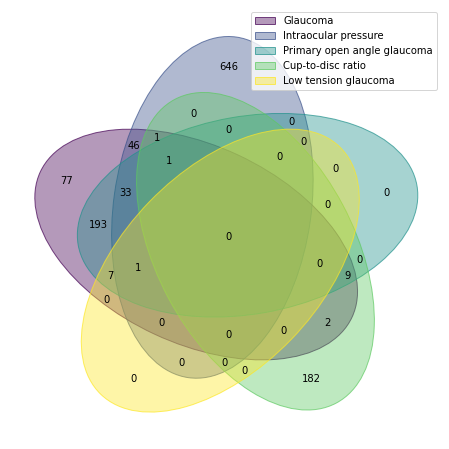

In [25]:
venn.venn({
    'Glaucoma':set(combined_snp_df[combined_snp_df['ANY_GLAUCOMA']].index),
    'Intraocular pressure':set(combined_snp_df[combined_snp_df['IOP']].index),
    'Primary open angle glaucoma':set(combined_snp_df[combined_snp_df['POAG']].index),
    'Cup-to-disc ratio':set(combined_snp_df[combined_snp_df['VCDR']].index),
    'Low tension glaucoma':set(combined_snp_df[combined_snp_df['LTG']].index)
}, legend_loc="best", fontsize=10)

In [66]:
def get_id_in_ukbb(chrom, pos, rsid):
    if rsid in df_found_genes['ID'].values:
        return rsid
    if str(chrom)+':'+str(pos) in [str(c)+':'+str(p) for c,p in zip(df_found_genes['#CHROM'], df_found_genes['POS'])]:
        if rsid in snp_found_in_the_right_position_but_wrong_mutation:
            return 'Wrong SNP found at right position'
        else:
            id_identified = df_found_genes[pd.Series([str(c)+':'+str(p) for c,p in zip(df_found_genes['#CHROM'], df_found_genes['POS'])]) == str(chrom)+':'+str(pos)]['ID'].values[0]
            return id_identified
    if rsid in pseudonym_dict.keys():
        for psuedonym in pseudonym_dict[rsid]:
            if psuedonym in df_found_genes['ID'].values:
                return psuedonym
    return 'Absent'

In [67]:
combined_snp_df['ID in UKBB'] = [get_id_in_ukbb(chrom, pos, rsid) for chrom, pos, rsid in zip(combined_snp_df['NEW_CHR_ID'], combined_snp_df['NEW_CHR_POS'], combined_snp_df['SNPS'])]

In [11]:
combined_snp_df['ID in UKBB']

0        rs2041895
1        rs1333037
2         rs284491
3        rs4657477
4       rs12494328
           ...    
1193     rs7311936
1194     rs7717697
1195     rs1681739
1196     rs2920293
1197     rs8015152
Name: ID in UKBB, Length: 1198, dtype: object

In [69]:
combined_snp_df.to_pickle(UKBB_PATH+'processed_data/gene_data.pkl')

In [2]:
combined_snp_df = pd.read_pickle(UKBB_PATH+'processed_data/gene_data.pkl')

In [5]:
combined_snp_df[combined_snp_df['ID in UKBB'] == 'rs10908363']

,CHR_ID,CHR_POS,SNPS,POAG,LTG,ANY_GLAUCOMA,IOP,VCDR,ID_AND_POS,NEW_ID_AND_POS,NEW_CHR_ID,NEW_CHR_POS,ARB_START,ARB_END,Status,ID in UKBB
130,1,37611020,rs10908363,True,False,True,False,False,1:37611020,"(1, 38076621)",1,38076621,38076521,38076721,ID present,rs10908363


In [70]:
sample_line = get_line_by_index(30,'extracted_snps_chr1_7.vcf')

100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 148.70it/s]


In [71]:
lines = []
with open(UKBB_PATH+'processed_data/extracted_snps_chr1_7.vcf', 'r') as f:
    for line in tqdm(f, total=4274):
        this_line = line.split('\t')
        if this_line[0][0] != '#':
            if this_line[2] in combined_snp_df['ID in UKBB'].values:
                processed_line = this_line[:9] + list((map(lambda x:{'0/0':0, '0/1':1, '1/1':2, './.':np.nan, '0/0\n':0, '0/1\n':1, '1/1\n':2, './.\n':np.nan}[x.split(':')[0]],this_line[9:])))
                lines.append(processed_line)

100%|██████████████████████████████████████| 4274/4274 [04:36<00:00, 15.44it/s]


In [72]:
with open(UKBB_PATH+'processed_data/extracted_snps_chr8_22.vcf', 'r') as f:
    for line in tqdm(f, total=5459):
        this_line = line.split('\t')
        if this_line[0][0] != '#':
            if this_line[2] in combined_snp_df['ID in UKBB'].values:
                processed_line = this_line[:9] + list((map(lambda x:{'0/0':0, '0/1':1, '1/1':2, './.':np.nan, '0/0\n':0, '0/1\n':1, '1/1\n':2, './.\n':np.nan}[x.split(':')[0]],this_line[9:])))
                lines.append(processed_line)

100%|██████████████████████████████████████| 5459/5459 [06:02<00:00, 15.06it/s]


In [73]:
with open(UKBB_PATH+'processed_data/extracted_snps_chrX.vcf', 'r') as f:
    for line in tqdm(f, total=68):
        this_line = line.split('\t')
        if this_line[0][0] != '#':
            if this_line[2] in combined_snp_df['ID in UKBB'].values:
                processed_line = this_line[:9] + list((map(lambda x:{'0':0, '1':1, '1\n':1, '.':np.nan, '0/0':0, '0/1':1, '1/1':2, './.':np.nan, '0/0\n':0, '0/1\n':1, '1/1\n':2, './.\n':np.nan}[x.split(':')[0]],this_line[9:])))
                lines.append(processed_line)

100%|██████████████████████████████████████████| 68/68 [00:04<00:00, 14.49it/s]


In [78]:
len(lines)

1187

In [79]:
df_gene_data = pd.DataFrame()
df_gene_data['Participant'] = header_line

In [80]:
df_gene_data_X = pd.DataFrame()
df_gene_data_X['Participant'] = header_lineX

In [81]:
for line in tqdm(lines):
    if line[2] == 'rs6969706':
        if line[4] == 'T':
            df_gene_data[line[2]] = line
    elif line[2] == 'rs2920293':
        if line[4] == 'G':
            df_gene_data[line[2]] = line
    else:
        if len(line) == len(df_gene_data_X):
            df_gene_data_X[line[2]] = line
        else:
            df_gene_data[line[2]] = line

  8%|███▎                                    | 98/1187 [00:01<00:15, 69.06it/s]/tmp/ipykernel_1186644/1274946099.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_gene_data[line[2]] = line
 37%|██████████████▍                        | 441/1187 [00:06<00:10, 69.07it/s]/tmp/ipykernel_1186644/1274946099.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_gene_data[line[2]] = line
 57%|██████████████████████▏                | 677/1187 [00:09<00:07, 68.37it/s]/tmp/ipykernel_1186644/1274946099.py:7: PerformanceWarning: Data

In [89]:
df_gene_data = df_gene_data.iloc[9:].copy().reset_index(drop=True)
df_gene_data_X = df_gene_data_X.iloc[9:].copy().reset_index(drop=True)

In [92]:
df_gene_data.iloc[487408]['Participant'] = '1017711_1017711'
df_gene_data_X.iloc[486756]['Participant'] = '1017711_1017711'

In [95]:
df_gene_data_all = pd.merge(df_gene_data, df_gene_data_X, how='outer', on='Participant')

In [99]:
df_gene_data_all.to_pickle(UKBB_PATH+'processed_data/extracted_genes.pkl')

In [100]:
df_gene_data_all = pd.read_pickle(UKBB_PATH+'processed_data/extracted_genes.pkl')